In [1]:
import os
import glob
import topmed_manuscript_clean as tm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np


def add_legend_from_colors(labels, cmap, ax, loc='best', reverse=False):
    """
    Given a dictionary from label --> color and a matplotlib ax,
    add a legend to the ax
    """
    floats = [i/(len(labels) - 1) for i in range(len(labels))]
    c = matplotlib.cm.get_cmap(cmap) if isinstance(cmap, str) else cmap
    d = {label: {'facecolor': c(f)} for label, f in zip(labels, floats)}
    legend_elements = [Patch(label=label, **kwargs) for label, kwargs in d.items()]
    if reverse:
        legend_elements = legend_elements[::-1]
    ax.legend(handles=legend_elements, loc=loc)
    return ax


def hack_cmap(cmap_name, n):
    cmap = mpl.cm.get_cmap(cmap_name)
    cmap = cmap(range(256))
    cmap = cmap[np.linspace(0, 255, n+1).astype(int)[:-1]]
    return ListedColormap(cmap)

PREFIX = 'Fig2A.'
METADATA = '../../manuscript-intermediate-processing/data/metadata/metadata.tm.txt'

In [2]:
# load in primary hits
CIS_EQTL_PERMUTATIONS_GLOB = glob.glob('../../manuscript-intermediate-processing/data/scan-results/joint/cis-eqtl/permutations/maf*/*.txt.gz')
CIS_SQTL_PERMUTATIONS_GLOB = glob.glob('../../manuscript-intermediate-processing/data/scan-results/joint/cis-sqtl/permutations/maf*/*.txt.gz')
cis_eqtl_permutations_all = pd.concat([pd.read_csv(f, sep='\t').assign(tissue=os.path.basename(f).split('.')[0], pcs=int(os.path.basename(f).split('.')[1]), maf='1%' if 'maf001' in f else '0.1%') for f in CIS_EQTL_PERMUTATIONS_GLOB])
cis_sqtl_permutations_all = pd.concat([pd.read_csv(f, sep='\t').assign(tissue=os.path.basename(f).split('.')[0], pcs=int(os.path.basename(f).split('.')[1]), maf='1%' if 'maf001' in f else '0.1%') for f in CIS_SQTL_PERMUTATIONS_GLOB])
cis_eqtl_permutations = cis_eqtl_permutations_all[cis_eqtl_permutations_all.tissue.map(tm.cis_eqtl_pcs) == cis_eqtl_permutations_all.pcs]
cis_sqtl_permutations = cis_sqtl_permutations_all[cis_sqtl_permutations_all.tissue.map(tm.cis_sqtl_pcs) == cis_sqtl_permutations_all.pcs]
permutations = pd.concat([cis_eqtl_permutations.assign(modality='cis-eQTL'), cis_sqtl_permutations.assign(modality='cis-sQTL')])
permutations['gene_id'] = permutations.phenotype_id.map(tm.phenotype_id_to_gene_id)

In [3]:
metadata = pd.read_csv(METADATA, sep='\t')
sample_size_dict = metadata[metadata.used_for_scan].groupby('tissue').size().to_dict()
tissue_order = list(sorted(sample_size_dict.keys(), key=lambda x: sample_size_dict[x], reverse=False))

In [4]:
CIS_EQTL_SUSIE_GLOB = glob.glob('../../manuscript-intermediate-processing/data/scan-results/joint/cis-eqtl/susie/maf*/*.cs.txt')
CIS_SQTL_SUSIE_GLOB = glob.glob('../../manuscript-intermediate-processing/data/scan-results/joint/cis-sqtl/susie/maf*/postprocessed/*.by-gene.cs.txt')
cis_eqtl_susie = pd.concat([pd.read_csv(f, sep='\t').assign(tissue=os.path.basename(f).split('.')[0], maf='1%' if 'maf001' in f else '0.1%') for f in CIS_EQTL_SUSIE_GLOB])
cis_sqtl_susie = pd.concat([pd.read_csv(f, sep='\t').assign(tissue=os.path.basename(f).split('.')[0], maf='1%' if 'maf001' in f else '0.1%') for f in CIS_SQTL_SUSIE_GLOB])
cis_susie = pd.concat([cis_eqtl_susie.assign(modality='cis-eQTL'), cis_sqtl_susie.assign(modality='cis-sQTL')])
cis_susie['gene_id'] = cis_susie.phenotype_id.map(tm.phenotype_id_to_gene_id)
cis_susie['unique_cs_id'] = cis_susie.phenotype_id + '___L' + cis_susie.cs_id.astype(str)
cis_susie.head()

,phenotype_id,variant_id,pip,af,cs_id,tissue,maf,modality,gene_id,unique_cs_id
0,ENSG00000112685.14,chr6_692805_C_G,1.000000,0.682804,1,Lung,1%,cis-eQTL,ENSG00000112685.14,ENSG00000112685.14___L1
1,ENSG00000112685.14,chr6_506781_A_G,0.043571,0.578234,2,Lung,1%,cis-eQTL,ENSG00000112685.14,ENSG00000112685.14___L2
2,ENSG00000112685.14,chr6_518078_G_A,0.038384,0.595662,2,Lung,1%,cis-eQTL,ENSG00000112685.14,ENSG00000112685.14___L2
3,ENSG00000112685.14,chr6_518480_A_T,0.071511,0.594888,2,Lung,1%,cis-eQTL,ENSG00000112685.14,ENSG00000112685.14___L2
4,ENSG00000112685.14,chr6_528568_T_C,0.058727,0.595275,2,Lung,1%,cis-eQTL,ENSG00000112685.14,ENSG00000112685.14___L2


In [5]:
# plot number of signals per e/sGene
signals_per_gene = cis_susie.groupby(['tissue', 'maf', 'modality', 'gene_id']).cs_id.nunique().rename('signals').reset_index()
all_esgenes = permutations.loc[permutations.qval<=0.05,['tissue', 'maf', 'modality', 'gene_id']]
signals_per_gene = all_esgenes.merge(signals_per_gene, how='left')
signals_per_gene.signals = signals_per_gene.signals.fillna(0).astype(int)
signals_per_gene.head()

,tissue,maf,modality,gene_id,signals
0,Lung,1%,cis-eQTL,ENSG00000112679.14,0
1,Lung,1%,cis-eQTL,ENSG00000112685.14,4
2,Lung,1%,cis-eQTL,ENSG00000272463.1,1
3,Lung,1%,cis-eQTL,ENSG00000271727.1,0
4,Lung,1%,cis-eQTL,ENSG00000281809.1,0


In [6]:
cs_size = cis_susie.groupby(['tissue', 'maf', 'modality', 'phenotype_id', 'cs_id']).variant_id.nunique().rename('variants').reset_index()
cs_size['size_bin'] = tm.bin_integers(cs_size.variants.to_list(), ['1', '2-5', '6-10', '11-99', '100+'])
cs_size.head()

,tissue,maf,modality,phenotype_id,cs_id,variants,size_bin
0,Lung,1%,cis-eQTL,ENSG00000000003.14,1,1,1
1,Lung,1%,cis-eQTL,ENSG00000000457.14,1,2,2-5
2,Lung,1%,cis-eQTL,ENSG00000000460.17,1,347,100+
3,Lung,1%,cis-eQTL,ENSG00000000460.17,2,33,11-99
4,Lung,1%,cis-eQTL,ENSG00000000971.15,1,12,11-99


In [7]:
cs_counts = cis_susie.groupby(['tissue', 'modality', 'maf']).unique_cs_id.nunique().rename('cs').reset_index()
cs_counts['sample_size'] = cs_counts.tissue.map(sample_size_dict)
primary_signals = cis_susie.groupby(['tissue', 'maf', 'modality']).gene_id.nunique().rename('primary_signals').reset_index()
cs_counts = cs_counts.merge(primary_signals)
cs_counts['secondary_signals'] = cs_counts.cs - cs_counts.primary_signals
secondary_vs_primary_counts = cs_counts.drop(columns='cs').melt(id_vars=['tissue', 'maf', 'modality', 'sample_size'])
secondary_vs_primary_counts.variable = secondary_vs_primary_counts.variable.str.split('_', expand=True)[0]
secondary_vs_primary_counts = secondary_vs_primary_counts[(secondary_vs_primary_counts.maf=='1%')].pivot(index=['tissue', 'modality'], columns='variable', values='value').reset_index()
secondary_vs_primary_counts.head()

variable,tissue,modality,primary,secondary
0,Lung,cis-eQTL,15323,9815
1,Lung,cis-sQTL,7389,8105
2,Monocyte,cis-eQTL,7732,2550
3,Monocyte,cis-sQTL,3009,1983
4,Nasal_epithelial,cis-eQTL,10078,2606


In [8]:
tmp = cs_size.copy()
tmp['single_variant'] = (tmp.variants == 1).astype(int)
tmp.groupby(['tissue', 'maf', 'modality']).single_variant.mean().reset_index().pivot(index=['tissue', 'maf'], values='single_variant', columns='modality')

modality               cis-eQTL  cis-sQTL
tissue           maf                     
Lung             1%    0.211353  0.221311
Monocyte         1%    0.201031  0.226162
Nasal_epithelial 1%    0.135367  0.155126
PBMC             1%    0.292799  0.296674
T_cell           1%    0.200085  0.216314
Whole_blood      0.1%  0.403214  0.381503
                 1%    0.411590  0.374420

In [9]:
print('At a minimum minor allele frequency (MAF) threshold of 0.01, we identified {:,} - {:,} genes with a significant cis-eQTL (cis-eGenes) and {:,} - {:,} genes with a significant cis-sQTL (cis-sGenes)'.format(
 all_esgenes[(all_esgenes.maf=='1%') & (all_esgenes.modality=='cis-eQTL')].groupby('tissue').gene_id.nunique().min(),
 all_esgenes[(all_esgenes.maf=='1%') & (all_esgenes.modality=='cis-eQTL')].groupby('tissue').gene_id.nunique().max(),
 all_esgenes[(all_esgenes.maf=='1%') & (all_esgenes.modality=='cis-sQTL')].groupby('tissue').gene_id.nunique().min(),
 all_esgenes[(all_esgenes.maf=='1%') & (all_esgenes.modality=='cis-sQTL')].groupby('tissue').gene_id.nunique().max()))

At a minimum minor allele frequency (MAF) threshold of 0.01, we identified 9,330 - 19,465 genes with a significant cis-eQTL (cis-eGenes) and 3,290 - 8,795 genes with a significant cis-sQTL (cis-sGenes)


In [10]:
print('This identified {:,} - {:,} and {:,} - {:,} total cis-eQTL and cis-sQTL signals per tissue, respectively'.format(
    cis_susie[(cis_susie.maf=='1%') & (cis_susie.modality=='cis-eQTL')].groupby('tissue').unique_cs_id.nunique().min(),
    cis_susie[(cis_susie.maf=='1%') & (cis_susie.modality=='cis-eQTL')].groupby('tissue').unique_cs_id.nunique().max(),
    cis_susie[(cis_susie.maf=='1%') & (cis_susie.modality=='cis-sQTL')].groupby('tissue').unique_cs_id.nunique().min(),
    cis_susie[(cis_susie.maf=='1%') & (cis_susie.modality=='cis-sQTL')].groupby('tissue').unique_cs_id.nunique().max()
))

This identified 10,282 - 69,766 and 4,992 - 35,770 total cis-eQTL and cis-sQTL signals per tissue, respectively


In [11]:
signals_per_gene.head()

,tissue,maf,modality,gene_id,signals
0,Lung,1%,cis-eQTL,ENSG00000112679.14,0
1,Lung,1%,cis-eQTL,ENSG00000112685.14,4
2,Lung,1%,cis-eQTL,ENSG00000272463.1,1
3,Lung,1%,cis-eQTL,ENSG00000271727.1,0
4,Lung,1%,cis-eQTL,ENSG00000281809.1,0


In [12]:
print('In whole blood, we discovered a mean of {} cis-eQTL and {} cis-sQTL credible sets per cis-e/sGene'.format(
    signals_per_gene[(signals_per_gene.tissue=='Whole_blood') & (signals_per_gene.maf=='1%') & (signals_per_gene.modality=='cis-eQTL')].signals.mean(),
    signals_per_gene[(signals_per_gene.tissue=='Whole_blood') & (signals_per_gene.maf=='1%') & (signals_per_gene.modality=='cis-sQTL')].signals.mean()
))

In whole blood, we discovered a mean of 3.5841767274595426 cis-eQTL and 1.9442865264354747 cis-sQTL credible sets per cis-e/sGene


In [13]:
print('{} ({}%) of whole blood cis-eQTL and {} ({}%) of whole blood cis-sQTL credible sets contained a single variant'.format(
    sum(cs_size[(cs_size.tissue=='Whole_blood') & (cs_size.maf=='1%') & (cs_size.modality=='cis-eQTL')].variants==1),
    round((cs_size[(cs_size.tissue=='Whole_blood') & (cs_size.maf=='1%') & (cs_size.modality=='cis-eQTL')].variants==1).mean()*100, 1),
    sum(cs_size[(cs_size.tissue=='Whole_blood') & (cs_size.maf=='1%') & (cs_size.modality=='cis-sQTL')].variants==1),
    round((cs_size[(cs_size.tissue=='Whole_blood') & (cs_size.maf=='1%') & (cs_size.modality=='cis-sQTL')].variants==1).mean()*100, 1)
))

28715 (41.2%) of whole blood cis-eQTL and 13393 (37.4%) of whole blood cis-sQTL credible sets contained a single variant


In [14]:
secondary_vs_primary_counts.head()

variable,tissue,modality,primary,secondary
0,Lung,cis-eQTL,15323,9815
1,Lung,cis-sQTL,7389,8105
2,Monocyte,cis-eQTL,7732,2550
3,Monocyte,cis-sQTL,3009,1983
4,Nasal_epithelial,cis-eQTL,10078,2606


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_2634176/713565827.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signals_bin'] = tm.bin_integers(df.signals.to_list(), bin_names)
/tmp/ipykernel_2634176/2709527320.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap_name)
/tmp/ipykernel_2634176/713565827.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['tissue', 'signal

/tmp/ipykernel_2634176/713565827.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['tissue', 'size_bin']).size().reset_index().pivot(index='tissue', columns='size_bin', values=0).loc[tissue_order,:].plot(legend=False, kind='bar', stacked=True, ax=ax, align=align, width=width, cmap=cmap, hatch=hatch, edgecolor=edgecolor, alpha=alpha, label=modality)


/tmp/ipykernel_2634176/2709527320.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(cmap_name)
/tmp/ipykernel_2634176/713565827.py:56: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['tissue', 'size_bin']).size().reset_index().pivot(index='tissue', columns='size_bin', values=0).loc[tissue_order,:].plot(legend=False, kind='bar', stacked=True, ax=ax, align=align, width=width, cmap=cmap, hatch=hatch, edgecolor=edgecolor, alpha=alpha, label=modality)
/tmp/ipykernel_2634176/2709527320.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed tw

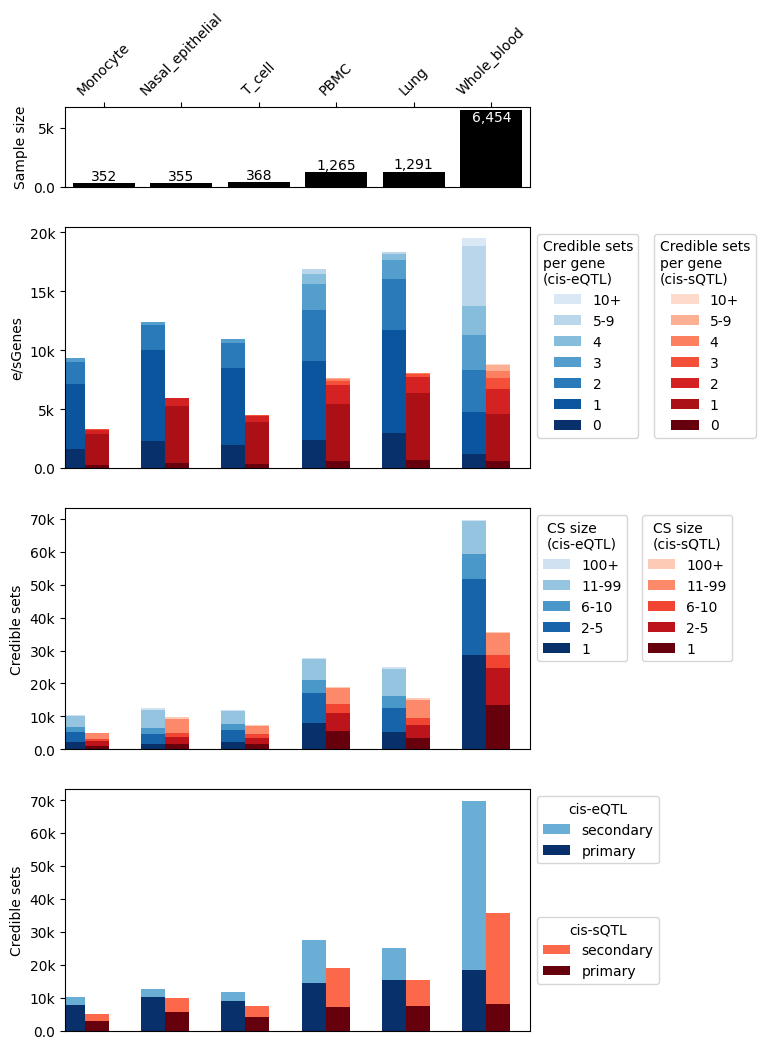

In [15]:
fig, axs = plt.subplots(nrows=4, figsize=(6, 12), gridspec_kw={'height_ratios': [1, 3, 3, 3]})


ax = axs[0]
sample_size_df = pd.DataFrame([[k, v] for k, v in sample_size_dict.items()], columns=['tissue', 'n']).sort_values('n')
sns.barplot(x='tissue', y='n', data=sample_size_df, color='black', dodge=False, ax=ax)
[ax.text(x=i, y=n, s='{:,}'.format(n), ha='center', va='bottom' if n != sample_size_df.n.max() else 'top', color='black' if n != sample_size_df.n.max() else 'white') for i, n in enumerate(sample_size_df.n)]
ax.legend().remove()
ax.set_ylabel('Sample size')
ax.set_xlabel('')
ax.xaxis.tick_top()
ax.yaxis.set_major_formatter(tm.bmk_formatter)
tm.rotate_xticklabels(ax, rot=45, ha='center')

ax = axs[1]
for i, modality in enumerate(['cis-eQTL', 'cis-sQTL']):
    df = signals_per_gene[(signals_per_gene.modality==modality) & (signals_per_gene.maf=='1%')]
    bin_ranges = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 9), (10, 99)]
    bin_names = ['0', '1', '2', '3', '4', '5-9', '10+']
    df['signals_bin'] = tm.bin_integers(df.signals.to_list(), bin_names)

    align = 'edge'
    width = -0.3 if modality == 'cis-eQTL' else 0.3
    edgecolor = None
    alpha = 1 if modality == 'cis-sQTL' else 1
    hatch = None
    cmap = 'Reds_r' if modality == 'cis-sQTL' else 'Blues_r'
    cmap = hack_cmap(cmap, len(bin_names))

    df.groupby(['tissue', 'signals_bin']).size().reset_index().pivot(index='tissue', columns='signals_bin', values=0).loc[tissue_order,:].plot(kind='bar', stacked=True, ax=ax, align=align, width=width, cmap=cmap, hatch=hatch, edgecolor=edgecolor, alpha=alpha, legend=False)
ax.set_ylabel('e/sGenes')
ax.set_xticks([])
ax.set_xlabel('')
ax.yaxis.set_major_formatter(tm.bmk_formatter)
add_legend_from_colors(df.signals_bin.cat.categories.to_list(), hack_cmap('Blues_r', len(df.signals_bin.cat.categories.to_list())), ax, reverse=True)
ax.get_legend().set_title('Credible sets\nper gene\n(cis-eQTL)')
ax.get_legend().set_bbox_to_anchor((1, 1))
ax.add_artist(ax.get_legend())

add_legend_from_colors(df.signals_bin.cat.categories.to_list(), hack_cmap('Reds_r', len(df.signals_bin.cat.categories.to_list())), ax, reverse=True)
ax.get_legend().set_title('Credible sets\nper gene\n(cis-sQTL)')
ax.get_legend().set_bbox_to_anchor((1.50, 1))
tm.rotate_xticklabels(ax)

ax = axs[2]
for i, modality in enumerate(['cis-eQTL', 'cis-sQTL']):
    df = cs_size[(cs_size.modality==modality) & (cs_size.maf=='1%')]
    align = 'edge'
    width = -0.3 if modality == 'cis-eQTL' else 0.3
    edgecolor = None
    alpha = 1 if modality == 'cis-sQTL' else 1
    hatch = None
    cmap = 'Reds_r' if modality == 'cis-sQTL' else 'Blues_r'
    cmap = hack_cmap(cmap, len(df.size_bin.cat.categories.to_list()))

    df.groupby(['tissue', 'size_bin']).size().reset_index().pivot(index='tissue', columns='size_bin', values=0).loc[tissue_order,:].plot(legend=False, kind='bar', stacked=True, ax=ax, align=align, width=width, cmap=cmap, hatch=hatch, edgecolor=edgecolor, alpha=alpha, label=modality)
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('Credible sets')
ax.yaxis.set_major_formatter(tm.bmk_formatter)

add_legend_from_colors(df.size_bin.cat.categories.to_list(), hack_cmap('Blues_r', len(df.size_bin.cat.categories.to_list())), ax, reverse=True)
ax.get_legend().set_title('CS size\n(cis-eQTL)')
ax.get_legend().set_bbox_to_anchor((1, 1))
ax.add_artist(ax.get_legend())

add_legend_from_colors(df.size_bin.cat.categories.to_list(), hack_cmap('Reds_r', len(df.size_bin.cat.categories.to_list())), ax, reverse=True)
ax.get_legend().set_title('CS size\n(cis-sQTL)')
ax.get_legend().set_bbox_to_anchor((1.45, 1))
tm.rotate_xticklabels(ax)



ax = axs[3]
for modality in ['cis-eQTL', 'cis-sQTL']:
    align = 'edge'
    width = -0.3 if modality == 'cis-eQTL' else 0.3
    cmap = 'Reds_r' if modality == 'cis-sQTL' else 'Blues_r'
    cmap = hack_cmap(cmap, 2)
    secondary_vs_primary_counts[secondary_vs_primary_counts.modality==modality].set_index('tissue').loc[tissue_order].plot(kind='bar', stacked=True, ax=ax, width=width, align=align, cmap=cmap, legend=False)
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('Credible sets')
ax.yaxis.set_major_formatter(tm.bmk_formatter)
add_legend_from_colors(['primary', 'secondary'], hack_cmap('Blues_r', 2), ax, reverse=True)
ax.get_legend().set_title('cis-eQTL')
ax.get_legend().set_bbox_to_anchor((1, 1))
ax.add_artist(ax.get_legend())

add_legend_from_colors(['primary', 'secondary'], hack_cmap('Reds_r', 2), ax, reverse=True)
ax.get_legend().set_title('cis-sQTL')
ax.get_legend().set_bbox_to_anchor((1, 0.5))
tm.rotate_xticklabels(ax)


fig.savefig(f'figures/{PREFIX}png', dpi=300, facecolor='white', bbox_inches='tight')